<a href="https://colab.research.google.com/github/Sreelakshmi2023/MAINPROJECT-GROUP12/blob/main/CNN_LSTM_ATTENTION(UPDATED).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Bidirectional, Attention, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
import pandas as pd
# Replace 'your_dataset.csv' with the
df = pd.read_csv('phishing.csv')

In [4]:
# Data preprocessing
max_words = 10000  # Maximum number of words to consider in the tokenizer
max_len = 100      # Maximum length of sequences


In [5]:
# Tokenization
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['url'])
sequences = tokenizer.texts_to_sequences(df['url'])

# Padding sequences
X = pad_sequences(sequences, maxlen=max_len)


In [6]:
# Encoding labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['type'])

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Model architecture
embedding_dim = 50  # Dimension of word embeddings
num_filters = 64    # Number of filters in the Conv1D layer
lstm_units = 64     # Number of units in the LSTM layer

# Input layer
inputs = Input(shape=(max_len,))

# Embedding layer
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len)(inputs)

# Convolutional layer
conv1d_layer = Conv1D(filters=num_filters, kernel_size=3, activation='relu')(embedding_layer)

# Max pooling layer
pooling_layer = MaxPooling1D(pool_size=2)(conv1d_layer)

# LSTM layer
lstm_layer = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(pooling_layer)

# Attention mechanism
attention_layer = Attention()([lstm_layer, lstm_layer])

# Flatten the output from the attention layer
flattened_output = Flatten()(attention_layer)

# Dense layer
outputs = Dense(4, activation='softmax')(flattened_output)  # Number of classes is 4



In [9]:
# Model compilation
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 50)              500000    ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 98, 64)               9664      ['embedding[0][0]']           
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 49, 64)               0         ['conv1d[0][0]']              
 D)                                                                                           

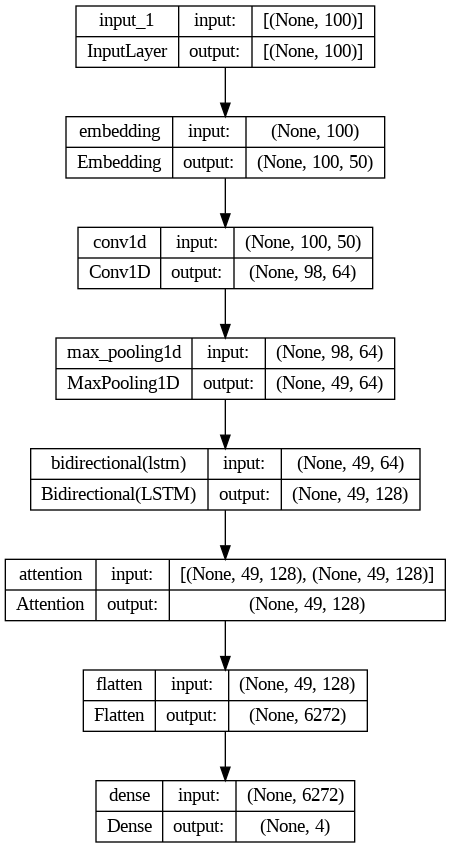

In [10]:
# Plot model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True)

In [12]:
# Model training
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/5
337/337 [==============================] - 20s 60ms/step - loss: 0.1968 - accuracy: 0.9335 - val_loss: 0.1444 - val_accuracy: 0.9484
Epoch 2/5
337/337 [==============================] - 8s 25ms/step - loss: 0.1080 - accuracy: 0.9613 - val_loss: 0.1153 - val_accuracy: 0.9580
Epoch 3/5
337/337 [==============================] - 5s 16ms/step - loss: 0.0838 - accuracy: 0.9695 - val_loss: 0.1175 - val_accuracy: 0.9592
Epoch 4/5
337/337 [==============================] - 5s 15ms/step - loss: 0.0741 - accuracy: 0.9731 - val_loss: 0.1118 - val_accuracy: 0.9622
Epoch 5/5
337/337 [==============================] - 6s 18ms/step - loss: 0.0690 - accuracy: 0.9748 - val_loss: 0.1173 - val_accuracy: 0.9612


In [13]:

# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
rounded_accuracy=round(accuracy,4)
print(f'Test Accuracy: {rounded_accuracy*100}')


421/421 [==============================] - 2s 5ms/step - loss: 0.1145 - accuracy: 0.9617
Test Loss: 0.11450660973787308
Test Accuracy: 96.17


In [14]:
# Prediction
def predict_url_type(url):
    sequence = tokenizer.texts_to_sequences([url])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    prediction = model.predict(padded_sequence)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]


In [15]:
# Example usage
user_input = input("Enter a URL to predict its type (e.g., 'example.com'): ")
prediction = predict_url_type(user_input)
print(f'Predicted URL type for {user_input}: {prediction}')

Enter a URL to predict its type (e.g., 'example.com'): www.yahoo.com
1/1 [==============================] - 1s 855ms/step
Predicted URL type for www.yahoo.com: benign


421/421 [==============================] - 2s 6ms/step
Accuracy: 0.9617
Precision: 0.9592
Recall: 0.9617
F1 Score: 0.9581
ROC AUC: 0.9912


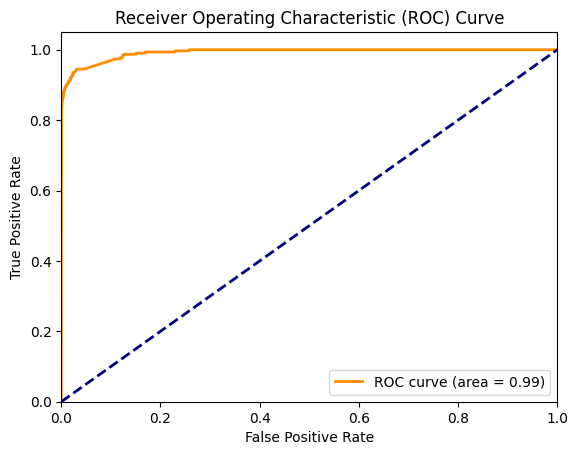

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred, average='macro', multi_class='ovr')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred[:, i], pos_label=i)
    roc_auc[i] = roc_auc_score((y_test == i).astype(int), y_pred[:, i])

plt.figure()
plt.plot(fpr[2], tpr[2], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
